<a href="https://colab.research.google.com/github/etckanikama/practice-repository/blob/main/ReservoirComputing_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

～変数の説明～

u(t): 時刻tにおける入力

Win: 入力層の重み

K: 入力層のノード数

x(t): 時刻tにおけるreservoir層の内部状態

X: x(t)の行列記法

Wres : Reservoir層の重み

N: Reservoir層のノード数

Wout: 出力層の重み

z(t): 出力

K: 出力層のノード数

reservioir層の内部状態x(t)の式

x(t)=f((1−δ)x(t−1)+δ(Win u(t−1)+Wres x(t−1)))　（１）

δ：漏れ率

δが小さければ小さいほど、第一項の寄与率が大きくなり、第二講の寄与率が小さくなる。

時刻t-1までの巻子の状態を保持しているx(t-1)の寄与率が大きくなり、直前の入力を表すu(t−1)の寄与率が小さくなるため、δが小さいほど過去の状態を長く覚えていられるようになるが直前の入力の影響が小さくなる。

逆にδが大きいほど直前の入力はよく覚えているが、過去の状態については極短期間しか覚えられない。

現在の入力u(t-1)、活性化関数fはtanhを使用する。

Woutの学習に関係する式

Wout=(X^TX+λI)^−1 X^TYtarget   　　(2)

リッジ回帰で正則化した行列Xと出力としてほしい理想値(教師データ)Ytargetの最小二乗誤差が0となる値をWoutに代入しているだけです。

最後に出力z(t)に関する式

z(t) = fout(Wout x(t))           　　　(3)

foutもtanhを使用する。

reservoir層の出力と出力層の重みの積和を活性化関数にかけるだけ


他に初期条件として、

Win: -0.1 or 0.1の一様分布

Wres: 平均0, 分散1の正規分布

x(0): ゼロ行列

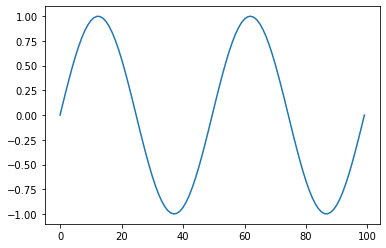

In [25]:
# sin関数を作ってくれるクラス
# np.dot = @ ：内積計算

import numpy as np
from scipy import linalg #線形代数を扱うパッケージ(linalg.invで逆行列を求められる)
import matplotlib.pyplot as plt


class InputGenerator:
  def __init__(self, start_time, end_time, num_time_steps):
      self.start_time = start_time
      self.end_time = end_time
      self.num_time_steps = num_time_steps 

  def generate_sin(self, amplitude=1.0):
      # np.linespace(最初の値,最後の値,要素数):
      return np.sin( np.linspace(self.start_time, self.end_time, self.num_time_steps) ) * amplitude

# sin波の描画ができるか確認
input_generator = InputGenerator(0,4*np.pi,100)
x = input_generator.generate_sin()
plt.plot(x)

In [26]:
# ESNのネットワークを作成するクラス：train()で学習predict()で学習
class ReservoirNetWork:
  def __init__(self,inputs,num_input_nodes, num_reservoir_nodes, num_output_nodes, leak_rate=0.1,activator=np.tanh):
      self.inputs = inputs # 学習で使う入力
      self.log_reservoir_nodes = np.array([np.zeros(num_reservoir_nodes)]) # reservoir層のノードの状態を記録

      # init weights
      self.weights_input = self._generate_variational_weights(num_input_nodes, num_reservoir_nodes)
      self.weights_reservoir = self._generate_reservoir_weights(num_reservoir_nodes)
      self.weights_output = np.zeros([num_reservoir_nodes, num_output_nodes])

      # それぞれの層のノードの数
      self.num_input_nodes = num_input_nodes
      self.num_reservoir_nodes = num_reservoir_nodes
      self.num_output_nodes = num_output_nodes

      self.leak_rate = leak_rate # 漏れ率
      self.activator = activator # 活性化関数
  
  # 出力層の重みを更新
  def _update_weights_output(self, lambda0):
      # Ridge Regression
      E_lambda0 = np.identity(self.num_reservoir_nodes) * lambda0 # lambda0
      inv_x = np.linalg.inv(self.log_reservoir_nodes.T @ self.log_reservoir_nodes + E_lambda0)
      # update weights of output layer
      self.weights_output = (inv_x @ self.log_reservoir_nodes.T) @ self.inputs
  
  # 学習する
  def train(self, lambda0=0.1):
      for input in self.inputs:
          current_state = np.array(self.log_reservoir_nodes[-1])
          self.log_reservoir_nodes = np.append(self.log_reservoir_nodes,
              [self._get_next_reservoir_nodes(input, current_state)], axis=0)
      self.log_reservoir_nodes = self.log_reservoir_nodes[1:]
      self._update_weights_output(lambda0)

  # 学習で得られた重みを基に訓練データを学習できているかを出力
  def get_train_result(self):
      outputs = []
      reservoir_nodes = np.zeros(self.num_reservoir_nodes)
      for input in self.inputs:
          reservoir_nodes = self._get_next_reservoir_nodes(input, reservoir_nodes)
          outputs.append(self.get_output(reservoir_nodes))
      return outputs

  # 予測する
  def predict(self, length_of_sequence, lambda0=0.01):
      predicted_outputs = [self.inputs[-1]] # 最初にひとつ目だけ学習データの最後のデータを使う
      reservoir_nodes = self.log_reservoir_nodes[-1] # 訓練の結果得た最後の内部状態を取得
      for _ in range(length_of_sequence):
          reservoir_nodes = self._get_next_reservoir_nodes(predicted_outputs[-1], reservoir_nodes)
          predicted_outputs.append(self.get_output(reservoir_nodes))
      return predicted_outputs[1:] # 最初に使用した学習データの最後のデータを外して返す

  # get output of current state
  def get_output(self, reservoir_nodes):
      # return self.activator(reservoir_nodes @ self.weights_output) 修正前
      return reservoir_nodes @ self.weights_output # 修正後
      
  # reservoir層のノードの次の状態を取得
  def _get_next_reservoir_nodes(self, input, current_state):
      next_state = (1 - self.leak_rate) * current_state
      next_state += self.leak_rate * (np.array([input]) @ self.weights_input
          + current_state @ self.weights_reservoir)
      return self.activator(next_state)

  # 重みを0.1か-0.1で初期化したものを返す
  def _generate_variational_weights(self, num_pre_nodes, num_post_nodes):
        return (np.random.randint(0, 2, num_pre_nodes * num_post_nodes).reshape([num_pre_nodes, num_post_nodes]) * 2 - 1) * 0.1

  # Reservoir層の重みを初期化
  def _generate_reservoir_weights(self, num_nodes):
        weights = np.random.normal(0, 1, num_nodes * num_nodes).reshape([num_nodes, num_nodes])
        spectral_radius = max(abs(linalg.eigvals(weights)))
        return weights / spectral_radius

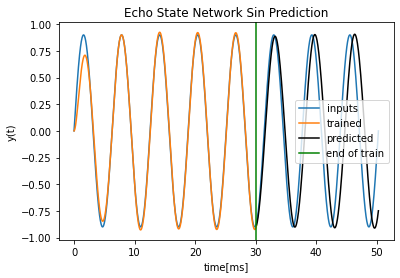

In [31]:
T = np.pi * 16 #今回学習させた時系列データ(sin)の実行時間16π(8周期分)
RATIO_TRAIN = 0.6 #訓練データに使う割合について、0.6はデータ全体の60%を訓練データとしてもいいている
dt = np.pi * 0.01 # 単位時間：今回の入力データにおける1ステップごとの経過時間を表す
AMPLITUDE = 0.9 #AMPLITUDE : 入力データの振幅です.[-0.9,0.9]の間を振動するようになってます.
LEAK_RATE=0.02
NUM_INPUT_NODES = 1
NUM_RESERVOIR_NODES = 150 #NUM_RESERVOIR_NODES : 中間層(リザーバー)のノード数です.多いほどより多くの情報(今回の場合は時系列データ)を内部に貯めこむことができます
NUM_OUTPUT_NODES = 1
NUM_TIME_STEPS = int(T/dt)

# example of activator
def ReLU(x):
    return np.maximum(0, x)

def main():
    # data：初期sin波の出力：amplitudeが不明
    i_gen = InputGenerator(0, T, NUM_TIME_STEPS)
    data = i_gen.generate_sin(amplitude=AMPLITUDE)

    # print(len(data)) #1599*0.6=60%を訓練データとする
    num_train = int(len(data) * RATIO_TRAIN)
    train_data = data[:num_train]
    # ネットワークモデルをインスタンス化→引数：
    model = ReservoirNetWork(inputs=train_data,#inputs=60%の訓練データ
        num_input_nodes=NUM_INPUT_NODES, #num_input_nodes:入力はsinなので当然1
        num_reservoir_nodes=NUM_RESERVOIR_NODES,#中間層（リザーバー）のノード数 
        num_output_nodes=NUM_OUTPUT_NODES, #sinのある値を予測するものなので当然1
        leak_rate=LEAK_RATE) #漏れ率＝なぜこの値になるのか検討が必要

    model.train() # 訓練
    train_result = model.get_train_result() # 訓練の結果を取得

    num_predict = int(len(data[num_train:]))
    predict_result = model.predict(num_predict)

    t = np.linspace(0, T, NUM_TIME_STEPS)
    ## plot
    plt.plot(t, data, label="inputs")
    plt.plot(t[:num_train], train_result, label="trained")
    plt.plot(t[num_train:], predict_result, label="predicted",color="black")
    plt.axvline(x=int(T * RATIO_TRAIN), label="end of train", color="green") # border of train and prediction
    plt.legend()
    plt.title("Echo State Network Sin Prediction")
    plt.xlabel("time[ms]")
    plt.ylabel("y(t)")
    plt.show()
if __name__=="__main__":
    main()